In [60]:
import rank
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import spectral_clustering
from sklearn import metrics
import scipy
import seaborn as sns
%matplotlib inline
np.random.seed(10)

Y Graph Hierarchy
===================

This graph has a structure like letter 'Y' with two parallel hierarchies at the top.

Scores drawn from three normal distribution: N(0, 0.5), N(4, 1), N(4, 1), Beta[0.1, 5] and C so that average degree is 5.
    
Graph A: Greated with generative model. Nodes drawn from the two N(4,1) distribution are prevented from connecting with one another to create a Y graph structure.

Graph B: Created with generative model.

Some ideas for graphs:

Figure 1a: Correlation of scores inferred from Graph A and B
Figure 1b: Distribution of scores inferred from Graph A and B

Figure 2: Compare correlation matrix of Graph A and B

Figure 3: Clustering errors in indentifying the parallel communities for each Beta

Figure 4a and 4b: Parallel communities for Graph A with a low and high Beta value

Repeat all analysis for 'Y' graph with decreasing size of the parallel parts.

In [ ]:
# Declare constants

colors_list = ['r','g','b','c','m','y','k','w']
trunk_lengths = np.arange(1,100,10)
n = 101 
reps = 1
trials = 6

beta_hat_list = np.zeros((trunk_lengths.size, reps))
c_hat_list = np.zeros((trunk_lengths.size, reps))

homogeneity = np.zeros((trunk_lengths.size, reps)) #using delta correlation
completeness = np.zeros((trunk_lengths.size, reps))
vmeasure = np.zeros((trunk_lengths.size, reps))

homogeneity2 = np.zeros((trunk_lengths.size, reps)) #using just correlation
completeness2 = np.zeros((trunk_lengths.size, reps))
vmeasure2 = np.zeros((trunk_lengths.size, reps))

homogeneity3 = np.zeros((trunk_lengths.size, reps)) #using just rankings
completeness3 = np.zeros((trunk_lengths.size, reps))
vmeasure3 = np.zeros((trunk_lengths.size, reps))

homogeneity4 = np.zeros((trunk_lengths.size, reps)) #using partition on the network
completeness4 = np.zeros((trunk_lengths.size, reps))
vmeasure4 = np.zeros((trunk_lengths.size, reps))


correlations_A = np.zeros((trunk_lengths.size,n,n))
correlations_B = np.zeros((trunk_lengths.size,n,n))
delta_correlations = np.zeros((trunk_lengths.size,n,n))

scores_Graph_As = np.zeros((trunk_lengths.size, n))
scores_Graph_Bs = np.zeros((trunk_lengths.size, n))

In [ ]:
# Y graph with different sizes of parallel parts


for t in range(trunk_lengths.size):
    trunk_length = trunk_lengths[t]
    Graph_A = np.zeros((n,n))
    
    # manually make Y graph
    start_snd_branch =  int(trunk_length + (n-trunk_length)/2)
    for i in range(start_snd_branch-1):
        Graph_A[i+1, i] = 1
    Graph_A[start_snd_branch, trunk_length] = 1
    for j in range(start_snd_branch, n-1):
        Graph_A[j+1, j] = 1
    
    # real community membership
    groups = np.concatenate((np.repeat(0, trunk_length), np.repeat(1, (n-trunk_length)/2), np.repeat(2, (n-trunk_length)/2)))
    
    # SpringRank scores and correlations
    out = rank.spring_rank(Graph_A)
    scores_Graph_A = out[0]
    sigma_Graph_A = out[1]
    correlation_A = rank.pearson_correlation(sigma_Graph_A)
    
    correlations_A[t,:,:] = correlation_A
    scores_Graph_As[t,:] = scores_Graph_A
    
    for r in range(reps):
        n_clusters = 3 #When we know true number of clutser
        
        #Using just correlation:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(correlation_A)
        groups_pred = kmeans.labels_
        homogeneity2[t, r] = metrics.homogeneity_score(groups, groups_pred)  
        completeness2[t, r] = metrics.completeness_score(groups, groups_pred)
        vmeasure2[t, r] = metrics.v_measure_score(groups, groups_pred)
        
        
        #Using the rankings:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scores_Graph_A.reshape((n,1)))
        groups_pred = kmeans.labels_
        homogeneity3[t, r] = metrics.homogeneity_score(groups, groups_pred)  
        completeness3[t, r] = metrics.completeness_score(groups, groups_pred)
        vmeasure3[t, r] = metrics.v_measure_score(groups, groups_pred)
        
        
        #Using delta correlation
        
        #Estimate parameters for null model
        avg_degree = np.sum(Graph_A)/n
        beta_hat = rank.estimate_beta(Graph_A, scores_Graph_A) #MLE of beta and c from Y graph
        c_hat = rank.estimate_c(avg_degree, beta_hat, scores_Graph_A)
        beta_hat_list[t, r] = beta_hat
        c_hat_list[t,r] = c_hat

        #Create null model
        Graph_B = rank.generate_graph(s=scores_Graph_A, beta=beta_hat, c=c_hat)
        out = rank.spring_rank(Graph_B)
        scores_Graph_B = out[0]
        sigma_Graph_B = out[1]
        correlation_B = rank.pearson_correlation(sigma_Graph_B)

        delta_correlation = correlation_B - correlation_A
        
        if r==0:
            correlations_B[t,:,:] = correlation_B
            delta_correlations[t,:,:] = delta_correlation
            scores_Graph_Bs[t,:] = scores_Graph_B

        #cluster
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(delta_correlation)
        groups_pred = kmeans.labels_
        homogeneity[t, r] = metrics.homogeneity_score(groups, groups_pred)  
        completeness[t, r] = metrics.completeness_score(groups, groups_pred)
        vmeasure[t, r] = metrics.v_measure_score(groups, groups_pred)

In [5]:
beta_hat, c_hat #beta_hat is expected to be bigger than actual beta ?? just checking beta estimate

(array([ 138.50274709]), array([ 0.59411765]))

In [112]:
# beta_hat = 138.50274709
# c_hat = 0.59411765

Plot
=====

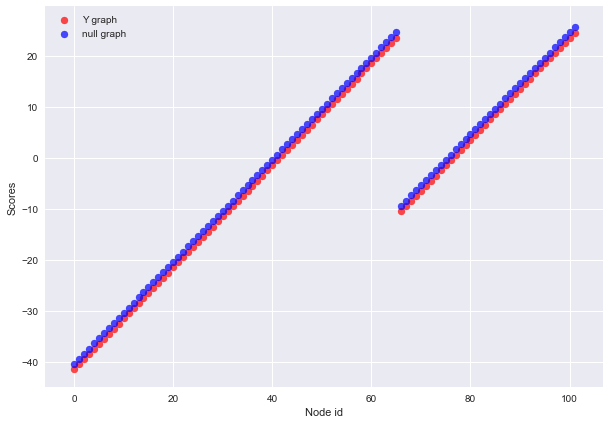

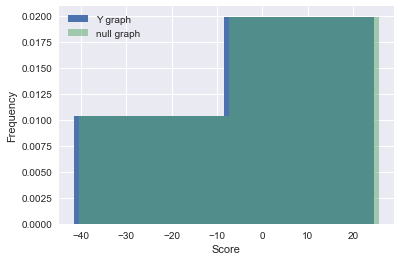

In [8]:
#Plot scores distribution with a density plot


bins=2
f, ax = plt.subplots()
ax.hist(scores_Graph_A, bins=bins, normed=True, label='Y graph');
ax.hist(scores_Graph_B, bins=bins, normed=True, alpha=0.5, label='null graph');
# sns.kdeplot(scores_Graph_A, bw=0.5, color='r');
# sns.kdeplot(scores_Graph_B, bw=0.5,  color='b');
ax.set_xlabel('Score');
ax.set_ylabel('Frequency');
ax.legend();


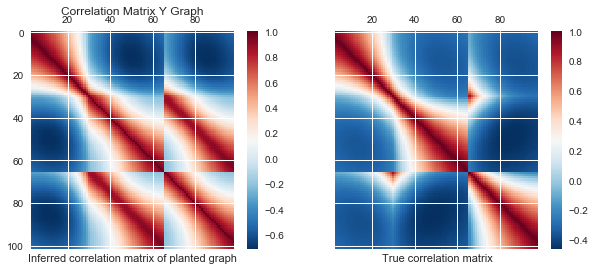

In [9]:
#Plot the correlation matrix of Y graph and its null model


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey=True)
im1 = ax1.matshow(correlation_B, cmap='RdBu_r');
ax1.set_title('Correlation Matrix Y Graph')
im2 = ax2.matshow(correlation_A, cmap='RdBu_r');
ax1.set_xlabel('Inferred correlation matrix of planted graph');
ax2.set_xlabel('True correlation matrix');
f.colorbar(im2, ax=ax2)
f.colorbar(im1, ax=ax1)
# plt.savefig('images/Y graph/second example/YGraph_sidebyside_s'+ str(beta)+'.png')

In [ ]:
#Plot clustering homogeneity and completeness for delta_correl, correlation, and ranks
#source https://stackoverflow.com/questions/21654635/scatter-plots-in-pandas-pyplot-how-to-plot-by-category
#error band: https://stackoverflow.com/questions/12957582/matplotlib-plot-yerr-xerr-as-shaded-region-rather-than-error-bars

#TODO: clean this up a little more


reps=1
colors = ['darkturquoise','orangered','m','greenyellow']
homos = [homogeneity, homogeneity2, homogeneity3]
coms = [completeness, completeness2, completeness3]
labels =[('DCH','DCC'),('CH','CC'),('SH','SC')]
f, ax = plt.subplots(figsize=(10,5))
ax.margins(0.05)
for i in range(len(homos)):
    error1=np.std(homos[i], axis=1)/math.sqrt(1)
    error2=np.std(coms[i], axis=1)/math.sqrt(1)
    ax.plot(trunk_lengths, np.mean(homos[i], axis=1), marker='o', label=labels[i][0], color=colors[i])
    ax.plot(trunk_lengths, np.mean(coms[i], axis=1), marker='o', ls='dotted', label=labels[i][1], color=colors[i])
    plt.fill_between(trunk_lengths, np.mean(homos[i], axis=1)-error1, np.mean(homos[i], axis=1)+error1, alpha=0.5, color=colors[i])
    plt.fill_between(trunk_lengths, np.mean(coms[i], axis=1)-error2, np.mean(coms[i], axis=1)+error2, alpha=0.5, color=colors[i])
ax.set_ylim([0,1])
ax.legend()
# plt.savefig('presentation/images/y graph/clustering_performance_over_trunk_length_dashed_8-6.png')

In [ ]:
data= np.load('y_graph_data_8-6.npz')

In [ ]:
#Plot density:

from scipy.stats import norm
from sklearn.neighbors import KernelDensity
for i in range( data['scores_A'].shape[0]):
    X =  data['scores_A'][i,:][:, np.newaxis]
    X_plot = np.linspace(np.min(X), np.max(X), 1000)[:, np.newaxis]
    fig, ax = plt.subplots()
    kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
    log_dens = kde.score_samples(X_plot) 
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format('gaussian'))
#     plt.savefig('presentation/images/y graph/scores/scoresA_dist_trunk'+str(i)+'.png')
    plt.clf()

In [ ]:
#Cluster results:

colors = ['darkturquoise','orangered','m','greenyellow']
for j in range(scores_Graph_As.shape[0]):
    n_clusters=3
    #cluster
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data['delta_correlation'][j,:,:])
    groups_pred = kmeans.labels_

    color = [ colors[i] for i in groups_pred]
    f = plt.figure(figsize=(3,13))
    plt.scatter(groups_pred, data['scores_A'][j,:] , color=color, alpha=0.5)
    plt.title('Y graph hierarchy')
    plt.ylabel('Scores')
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off') # labels along the bottom edge are off
#     plt.savefig('presentation/images/y graph/cluster/clusters_delta'+str(j)+'.png')
     plt.clf()